# WEEK 1

In [1]:
# imports 
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import random
import pickle

In [2]:
# DIRECTORIES
dataset_dir = "./dataset/BBDD"
test_1_dir = "./dataset/qsd1_w1"
test_2_dir = "./dataset/qsd2_w1"

# STEP 1. Image descriptor

In [7]:
# helper function - to convert rgb to gray scale image
def convert_rgb_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# helper function - to calculate histogram
def gen_1D_histogram(image):
    # return cv2.calcHist([image], [0], None, [256], [0, 256])
  histogram = [0] * 256
  for row in image:
      for pixel in row:
          histogram[pixel] += 1
  return histogram


# consider also 1D colored image histogram

In [ ]:
# To consider: preprocessing the images
# 1. Normalize pixelvalues within an image

# Same preprocessing as is applied here should also be applied prior to image retrieval step

    

# STEP 2: CALCULATE AND STORE 1D HISTOGRAM OF EACH IMAGE

In [8]:
database = {}
for file in tqdm(os.listdir(dataset_dir)):
    if ".jpg" in file:
        img = cv2.imread(os.path.join(dataset_dir,file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        gray_image = convert_rgb_to_grayscale(img)

        feature = gen_1D_histogram(gray_image)
        database[file] = feature

100%|██████████| 862/862 [06:53<00:00,  2.09it/s]


In [29]:
def load_vectorized_database(path=None):
    database = {}
    database_file_paths = [os.path.join(path, f )for f in os.listdir(path) if f.endswith('pkl')]
    for file in database_file_paths:
        corresponding_image_file = file.split('/')[-1].replace('pkl', 'jpg')
        with open(file, 'rb') as f:
            feature = pickle.load(f)
        database[corresponding_image_file] = feature
    return database
        

In [32]:
vector_db = load_vectorized_database(path='./dataset/BBDD_vectorized')

print(database['bbdd_00011.jpg'] == vector_db['bbdd_00011.jpg'])

True


In [10]:
# Save list as .pkl file

def save_as_pickle(list_, path):
  if not path.endswith('.pkl'):
    print(f'{path} is not a pickle compatible format')
  if type(list_) != type([0]):
    try:
      list_ = list(list_)
    except:
      print(f'{list_} is not a list and can not be converted to type: List')

  with open(path, 'wb') as fp:
    pickle.dump(list_, fp)

In [13]:
image_vector_dest = 'dataset/BBDD_vectorized/'
#os.makedirs(image_vector_dest)

for key, value in database.items():
    vector_save_path = key.replace('.jpg', '.pkl')
    vector_save_path = os.path.join(image_vector_dest, vector_save_path)
    save_as_pickle(list_=value,
                   path=vector_save_path)
    

# LINEAR SEARCH

In [14]:
def linear_retriever(input_image, top_k_match:int):
    similarity_tracker = {}

    # input image preprocessing
    gray_input_image = convert_rgb_to_grayscale(input_image)
    feature = gen_1D_histogram(gray_input_image)

    for key,val in database.items():
        similarity_tracker[key] = cosine_similarity([val], [feature])[0][0]

    # Sort the dictionary based on values, in descending order
    sorted_items = sorted(similarity_tracker.items(), key=lambda item: item[1], reverse=True)

    # # Get the top 5 keys
    top_k_images = dict(sorted_items[:top_k_match])
    return top_k_images



input image file name: bbdd_00179.jpg
resulted top k similar image:{'bbdd_00179.jpg': 1.0000000000000004, 'bbdd_00219.jpg': 0.9477088363023903, 'bbdd_00062.jpg': 0.9469519056435345, 'bbdd_00240.jpg': 0.9365674521644567, 'bbdd_00171.jpg': 0.8973163011532206}


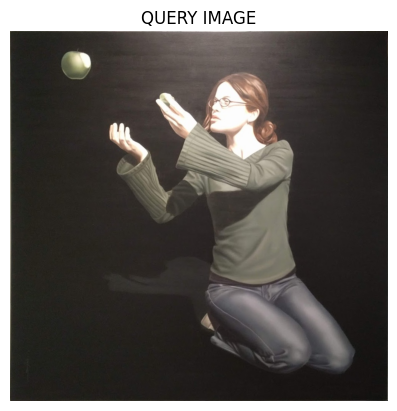

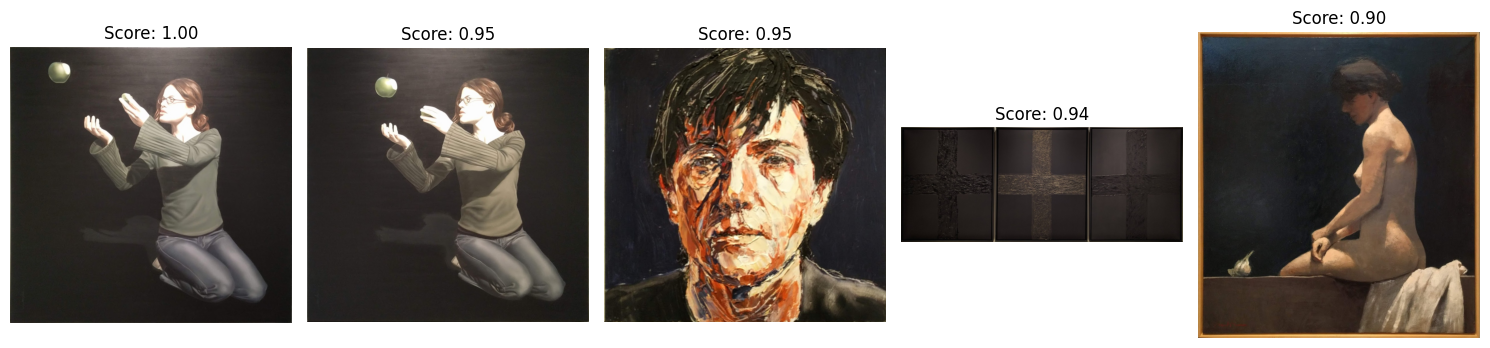

In [15]:
# TEST RETRIEVAL
all_images = [file for file in os.listdir(dataset_dir) if ".jpg" in file]
random_image_file = random.choice(all_images)
img = cv2.imread(os.path.join(dataset_dir,random_image_file))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



print(f"input image file name: {random_image_file}")
top_k_images = linear_retriever(input_image=img,top_k_match=5)

print(f"resulted top k similar image:{top_k_images}")

plt.imshow(img)
plt.title("QUERY IMAGE")
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 5))

# Loop through the images and plot them
for idx, (img_name, score) in enumerate(top_k_images.items()):
    img_path =os.path.join(dataset_dir,img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, idx+1)
    plt.imshow(img)
    plt.title(f"Score: {score:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()




# KD-TREE

In [16]:
from sklearn.neighbors import KDTree, BallTree

histograms = list(database.values())
# kd tree
tree = KDTree(histograms)


def kd_tree_retriever(input_image, top_k_match:int):
    similarity_tracker = {}

    # input image preprocessing
    gray_input_image = convert_rgb_to_grayscale(input_image)
    feature = gen_1D_histogram(gray_input_image)


    results = tree.query([feature], k=5)
    return results

    # # for key,val in database.items():
    # #     similarity_tracker[key] = cosine_similarity([val], [feature])[0][0]

    # # Sort the dictionary based on values, in descending order
    # sorted_items = sorted(similarity_tracker.items(), key=lambda item: item[1], reverse=True)

    # # # Get the top 5 keys
    # top_k_images = dict(sorted_items[:top_k_match])
    # return top_k_images



In [17]:
all_images = [file for file in os.listdir(dataset_dir) if ".jpg" in file]
random_image_file = random.choice(all_images)
img = cv2.imread(os.path.join(dataset_dir,random_image_file))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



print(f"input image file name: {random_image_file}")
top_k_images = kd_tree_retriever(input_image=img,top_k_match=5)

input image file name: bbdd_00028.jpg
